[View in Colaboratory](https://colab.research.google.com/github/opooladz/ESPRIT-Autoencoder-Anomaly-Detection/blob/master/AutoEncoder_&_ROC_Curves_ESPRIT.ipynb)

In [1]:
!pip3 install numba

    100% |████████████████████████████████| 1.9MB 9.2MB/s 
    100% |████████████████████████████████| 15.9MB 2.6MB/s 


In [2]:
import numpy as np
from scipy.linalg import toeplitz
from numpy import linalg as lg
from time import time
from typing import Tuple
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from numba import jit

flatten = lambda l: [item for sublist in l for item in sublist]

@jit
def compute_autocovariance(x: np.ndarray, M: int) -> np.ndarray:
    """
    This function compute the auto-covariance matrix of a numpy signal.
    The auto-covariance is computed as follows
    .. math:: \textbf{R}=\frac{1}{N}\sum_{M-1}^{N-1}\textbf{x}_{m}\textbf{x}_{m}^{H}
    where :math:`\textbf{x}_{m}^{T}=[x[m],x[m-1],x[m-M+1]]`.
    :param x: 1-D vector of size N
    :param M:  int, optional. Size of signal block.
    :returns: NxN ndarray
    """

    # Create covariance matrix for psd estimation
    # length of the vector x
    x = np.asarray(x).squeeze()
    assert x.ndim == 1, '1-D only'
    N = x.size

    # Create column vector (Nx1) from row array
    x_vect = x[None, :].T

    # init covariance matrix
    yn = x_vect[M-1::-1]  # reverse order from M-1 to 0

    R = yn @ yn.conj().T  # zeroth lag
    # about 5-8% of computation time
    for i in range(1, N-M):  # no zero because we just computed it
        # extract the column vector
        yn = x_vect[M-1+i:i-1:-1]

        R = R + yn @ yn.conj().T

    return R / N
@jit
def wrapper(x):
  return np.convolve(x,xc,mode="valid")

@jit
def esprit1(x: np.ndarray, L: int, M: int=None, fs: int=1,
           verbose: bool=False) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function estimate the frequency components based on the ESPRIT algorithm [ROY89]_
    The frequencies are related to the roots as :math:`z=e^{-2j\pi f/Fe}`.
    See [STO97]_ section 4.7 for more information about the implementation.
    :param x: ndarray, Nsamples
    :param L: int. Number of components to be extracted.
    :param M:  int, optional. Size of signal block.
    :param Fs: float. Sampling Frequency.
    :returns: ndarray ndarray containing the L frequencies
    >>> import numpy as np
    >>> import spectral_analysis.spectral_analysis as sa
    >>> Fe=500
    >>> t=1.*np.arange(100)/Fe
    >>> x=np.exp(2j*np.pi*55.2*t)
    >>> f=sa.Esprit(x,1,None,Fe)
    >>> print(f)
    """

    x = np.asarray(x).squeeze()
    assert x.ndim in (1, 2)
    # length of the vector x
    if x.ndim == 1:
        N = x.size
    else:
        N = x.shape[1]

    if M is None:
        M = N // 2
# %% extract signal subspace  99.9 % of computation time
    tic = time()
    if x.ndim == 1 and isinstance(M, int):
        R = compute_autocovariance(x, M)  # 75% of computation time        
    else:
        # the random phase of transmit/receive/target actually helps--need at least 5-6 observations to make useful
        R = np.cov(x, rowvar=False)
    if verbose:
        print('autocov sec.', time()-tic)
    # R = subspace.corrmtx(x.astype(complex128),M).astype(float) #f2py fortran

    tic = time()
    #U, S, V = lg.svd(R)  # 25% of computation time
    w, v = lg.eig(R)    
    idx = w.argsort()[::-1]   
    w = w[idx]
    v = v[:,idx]    
    if verbose:
        print('svd sec.', time()-tic)
# %% take eigenvalues and determine sinusoid frequencies
    # Remove last row
    S1 = v[:-1, :L]
    # Remove first row
    S2 = v[1:, :L]

    # Compute matrix Phi (Stoica 4.7.12)  <0.1 % of computation time
    Phi = lg.inv(S1.conj().T @ S1) @ S1.conj().T @ S2

    # Perform eigenvalue decomposition <0.1 % of computation time
    V, U = lg.eig(Phi)

    # extract frequencies ((note that there a minus sign since Yn are defined as [y(n), y(n-1),y(n-2),..].T))
    ang = -np.angle(V)

    # frequency normalisation
    f = fs*ang / (2.*np.pi)
    t = np.arange(0, 0.01, 1/fs)
    
    x2 = np.exp(-1j*2*np.pi*t[::-1])[:,np.newaxis]**f
    #display(xc.shape)
    #ampCisoid = np.apply_along_axis(lambda q: np.convolve(q,xc,mode="valid"),axis = 0,arr=x2)
    ampCisoid = np.apply_along_axis(wrapper,axis = 0,arr=x2)
    return f, np.abs(w[:L]), np.abs(ampCisoid)*1./480., np.angle(ampCisoid)
  

def esprit2(x: np.ndarray, L: int, M: int=None, fs: int=1,
           verbose: bool=False) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function estimate the frequency components based on the ESPRIT algorithm [ROY89]_
    The frequencies are related to the roots as :math:`z=e^{-2j\pi f/Fe}`.
    See [STO97]_ section 4.7 for more information about the implementation.
    :param x: ndarray, Nsamples
    :param L: int. Number of components to be extracted.
    :param M:  int, optional. Size of signal block.
    :param Fs: float. Sampling Frequency.
    :returns: ndarray ndarray containing the L frequencies
    >>> import numpy as np
    >>> import spectral_analysis.spectral_analysis as sa
    >>> Fe=500
    >>> t=1.*np.arange(100)/Fe
    >>> x=np.exp(2j*np.pi*55.2*t)
    >>> f=sa.Esprit(x,1,None,Fe)
    >>> print(f)
    """

    x = np.asarray(x).squeeze()
    assert x.ndim in (1, 2)
    # length of the vector x
    if x.ndim == 1:
        N = x.size
    else:
        N = x.shape[1]

    if M is None:
        M = N // 2
# %% extract signal subspace  99.9 % of computation time
    tic = time()
    if x.ndim == 1 and isinstance(M, int):
        R = compute_autocovariance(x, M)  # 75% of computation time
    else:
        # the random phase of transmit/receive/target actually helps--need at least 5-6 observations to make useful
        R = np.cov(x, rowvar=False)
    if verbose:
        print('autocov sec.', time()-tic)
    # R = subspace.corrmtx(x.astype(complex128),M).astype(float) #f2py fortran

    tic = time()
    U, S, V = lg.svd(R)  # 25% of computation time
    #w, v = lg.eig(R)    
    #idx = w.argsort()[::-1]   
    #w = w[idx]
    #v = v[:,idx]    
    if verbose:
        print('svd sec.', time()-tic)
# %% take eigenvalues and determine sinusoid frequencies
    # Remove last row
    S1 = U[:-1, :L]
    # Remove first row
    S2 = U[1:, :L]

    # Compute matrix Phi (Stoica 4.7.12)  <0.1 % of computation time
    Phi = lg.inv(S1.conj().T @ S1) @ S1.conj().T @ S2

    # Perform eigenvalue decomposition <0.1 % of computation time
    V, U = lg.eig(Phi)

    # extract frequencies ((note that there a minus sign since Yn are defined as [y(n), y(n-1),y(n-2),..].T))
    ang = -np.angle(V)

    # frequency normalisation
    f = fs*ang / (2.*np.pi)

    return f, S[:L]

Using TensorFlow backend.


In [0]:
from time import time
import numpy as np
from pandas import DataFrame

# Bool: Needs to be set by user 
full_anom = 0
anom_samples = 43

x = np.random.randn(4096).astype(np.complex128)
F = 12345.6

In [3]:
f0 = 12345.6
f1 = 1000.6
f2 = 726.6
f3 = 57.3

f0=np.random.uniform(low=0.,high = 10000.)
f1=np.random.uniform(low=0.,high = 10000.)
f2=np.random.uniform(low=0.,high = 10000.)
f3 = np.random.uniform(low=0.,high = 10000.)
display(f0)
display(f1)
display(f2)
display(f3)

c0 = 15.
c1 = 7.
c2 = 10.
c0= np.random.uniform(low=3.,high = 100.)
c1= np.random.uniform(low=3.,high = 100.)
c2= np.random.uniform(low=3.,high = 100.)
c3 = np.random.uniform(low=3.,high = 100.)
display(c0)
display(c1)
display(c2)
display(c3)

1541.3393921775842

5166.118363149034

7379.14489896736

8975.33329695861

27.838132490215898

64.68603074222807

86.3150600883311

48.76457053147328

Just check to see that the random values generated are not "too close."  But I want to make it random so I do not just get lucky on training and testing accuracy on some tunable parameters. 

In [0]:
fs = 48e3
snr = 20.  # dB
Ntone = 6

t = np.arange(0, 0.01, 1/fs)

nvar = 10**(-snr/10.)



M = [100] * 301  # iterating over block length

py = DataFrame(index=M, columns=['err', 'sigma','cisoidAmp','cisoidAngle'])
fortreal = DataFrame(index=M, columns=['err', 'sigma','cisoidAmp','cisoidAngle'])
fortcmpl = DataFrame(index=M, columns=['err', 'sigma','cisoidAmp','cisoidAngle'])
fest = []
fest2 = []
cisoidAmp = []
cisoidAmp2 = []
y_test = [] # lable 
i = 0
for m in M:
    i = i + 1
    for k in range(2):
      # Generate fist tripplet of cisoid  
      # Train data start
      xc = c0*np.exp(1j*2*np.pi*f0*t)+c1*np.exp(1j*2*np.pi*f1*t) +c2*np.exp(1j*2*np.pi*f2*t)
      xc1 = xc + np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))

      tmpFest, sigma,tmpAmp,cisoidAngle = esprit1(xc1, Ntone//2, M=m, fs=fs, verbose=False)
      fest.append(tmpFest)
      tmpAmp = tmpAmp[0]
      cisoidAmp.append(tmpAmp)
      # Train data end 
    
    # Test section start
    
    # Inject Anomaly
    if not(full_anom or i%40):
      #display(i)
      for j in np.arange(anom_samples):
        #display(i)
        AWGN = np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
        xc2 = c0*np.exp(1j*2*np.pi*f0*t)+c1*np.exp(1j*2*np.pi*f1*t) +c3*np.exp(1j*2*np.pi*f3*t) + AWGN
        tmpFest, sigma,tmpAmp,cisoidAngle = esprit1(xc2, Ntone//2, M=m, fs=fs, verbose=False)
        fest2.append(tmpFest)
        tmpAmp = tmpAmp[0]
        cisoidAmp2.append(tmpAmp) 
        # Anomaly has occured 
        y_test.append(1.)
    # When not Anomaly use xc as baseline signal and add AWGN - Run through esprit
    AWGN = np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
    xc2 = xc + AWGN
    if full_anom:
      # Anomaly has occured 
      y_test.append(1.)
      AWGN = np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
      xc2 = c0*np.exp(1j*2*np.pi*f0*t)+c1*np.exp(1j*2*np.pi*f1*t) +c3*np.exp(1j*2*np.pi*f3*t) + AWGN
    else:
      # Anomaly free sample 
        y_test.append(0.)
    tmpFest, sigma,tmpAmp,cisoidAngle = esprit1(xc2, Ntone//2, M=m, fs=fs, verbose=False)
    fest2.append(tmpFest)
    tmpAmp = tmpAmp[0]
    cisoidAmp2.append(tmpAmp)
    
    # Test section end 

# Create train and test set     
x_train = np.hstack((cisoidAmp,fest))    
x_test = np.hstack((cisoidAmp2,fest2))
    

In [343]:
#@title Model 1 - Elu { form-width: "20%" }
from keras import regularizers
from sklearn.preprocessing import StandardScaler
# Make sure to run this after each new generation of data

#1
# zero mean and unit var
# this makes train and test data zero mean and unit var individually 
# we should statistics of ideal data(no anomaly) 
# hense we should standadize both sets of data based on this
#x_train2 = StandardScaler().fit_transform(x_train)
#x_test2 = StandardScaler().fit_transform(x_test)

#2
# zero mean and unit var 
# scaler = StandardScaler().fit(x_train)
# x_train2 = scaler.transform(x_train)
# x_test2 = scaler.transform(x_test)

#3
#x_train2 = x_train
#x_test2 = x_test

#4
#zero mean and unit var 
scaler = StandardScaler().fit(x_test)
x_train2 = scaler.transform(x_train)
x_test2 = scaler.transform(x_test)

#x_train2 = x_train2[:,:,np.newaxis]
#x_test2 = x_test2[:,:,np.newaxis]

#x_train2 = x_train2.astype('float32') / 255.
#x_test2 = x_test2.astype('float32') / 255.

display(x_train2.shape)

input_dim = x_train.shape[1]

# set size of autoencoder 
encoding_dim = 6

# use elu because it is leaky tried both net and l1 and l2 : net and l1 worked the best 
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="elu",kernel_initializer= 'he_normal',
                activity_regularizer=regularizers.l1_l2(l1=10e-5, l2=75.10e-5))(input_layer)
#encoder = Dense(encoding_dim, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="elu",kernel_initializer= 'he_normal')(encoder)
decoder = Dense(int(encoding_dim / 2), activation='elu',kernel_initializer= 'he_normal')(encoder)
decoder = Dense(input_dim, activation='elu',kernel_initializer= 'he_normal')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()  


(602, 6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_49 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_50 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_51 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_52 (Dense)             (None, 6)                 24        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [344]:
#@title Model 2 - LeakyRelu { form-width: "20%" }
import keras
from keras import regularizers
from sklearn.preprocessing import StandardScaler
# Make sure to run this after each new generation of data

#1
# zero mean and unit var
# this makes train and test data zero mean and unit var individually 
# we should statistics of ideal data(no anomaly) 
# hense we should standadize both sets of data based on this
#x_train2 = StandardScaler().fit_transform(x_train)
#x_test2 = StandardScaler().fit_transform(x_test)

#2
# zero mean and unit var 
# scaler = StandardScaler().fit(x_train)
# x_train2 = scaler.transform(x_train)
# x_test2 = scaler.transform(x_test)

#3
#x_train2 = x_train
#x_test2 = x_test

#4
# zero mean and unit var 
scaler = StandardScaler().fit(x_test)
x_train2 = scaler.transform(x_train)
x_test2 = scaler.transform(x_test)

#x_train2 = x_train2[:,:,np.newaxis]
#x_test2 = x_test2[:,:,np.newaxis]

#x_train2 = x_train2.astype('float32') 
#x_test2 = x_test2.astype('float32')

display(x_train2.shape)

input_dim = x_train.shape[1]

# set size of autoencoder 
encoding_dim = 6
elu = keras.layers.ELU(alpha=1.2)
lrlu= keras.layers.LeakyReLU(alpha=0.3)


# use elu because it is leaky tried both net and l1 and l2 : net and l1 worked the best 
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim,kernel_initializer= 'he_normal', 
                activity_regularizer=regularizers.l1_l2(l1=10e-5, l2=75.10e-5))(input_layer)
encoder = keras.layers.LeakyReLU(alpha=0.011)(encoder)
#encoder = Dense(encoding_dim, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2),kernel_initializer= 'he_normal')(encoder)
encoder = keras.layers.LeakyReLU(alpha=0.011)(encoder)
decoder = Dense(int(encoding_dim / 2),kernel_initializer= 'he_normal')(encoder)
decoder = keras.layers.LeakyReLU(alpha=0.011)(decoder)
decoder = Dense(input_dim,kernel_initializer= 'he_normal')(decoder)
decoder = keras.layers.LeakyReLU(alpha=0.011)(decoder)
autoencoder2 = Model(inputs=input_layer, outputs=decoder)

autoencoder2.summary()  


(602, 6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 6)                 42        
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 6)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 3)                 21        
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_55 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 3)                 0         
__________

In [341]:
#@title Model 1 - Elu: Train/Test
training_set = "300 samples of anomaly free data " #@param {type:"string"}
validation_set = "Here I use the validation set as the test data. Has 300 anomaly free and 280 instances of of anomoly. " #@param {type:"string"}
history = "Contains both train and validation loss history" #@param {type:"string"}

#Results with 40 samples of anomily every 40 samples
full_anom = 0
anom_samples = 40
nb_epoch = 100 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.2,min_lr=1e-6,min_delta=0.00001,
                              patience=37,verbose = 1)


checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(x_test2, x_test2),
                    validation_split=.1,
                    shuffle=True,
                    verbose=1,callbacks=[reduce_lr, checkpointer, tensorboard]).history 

score = autoencoder.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)

display('[test_loss, test_acc]')
display(score)

Train on 602 samples, validate on 602 samples
Epoch 1/100
602/602 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.1578 - val_loss: 1.4253 - val_acc: 0.1528
Epoch 2/100
602/602 [==============================] - 0s 310us/step - loss: 0.0013 - acc: 0.1412 - val_loss: 1.4317 - val_acc: 0.0000e+00
Epoch 3/100
602/602 [==============================] - 0s 322us/step - loss: 0.0011 - acc: 0.1445 - val_loss: 1.4289 - val_acc: 0.1528
Epoch 4/100
602/602 [==============================] - 0s 313us/step - loss: 9.1187e-04 - acc: 0.1512 - val_loss: 1.4283 - val_acc: 0.0000e+00
Epoch 5/100
602/602 [==============================] - 0s 334us/step - loss: 7.7813e-04 - acc: 0.1395 - val_loss: 1.4327 - val_acc: 0.1528
Epoch 6/100
602/602 [==============================] - 0s 315us/step - loss: 6.7059e-04 - acc: 0.1528 - val_loss: 1.4366 - val_acc: 0.0000e+00
Epoch 7/100
602/602 [==============================] - 0s 325us/step - loss: 5.8984e-04 - acc: 0.1279 - val_loss: 1.4437 -

'[test_loss, test_acc]'

[1.7150949596774887, 0.15282392085984695]

Model 1 gives us a good result. We have a large gap (13 units) between the loss of the training set which has no anomalies  and the validation set which has ~50/50 normal/anomaly data.  We also have the training accuracy at 95% and the testing accuracy at 19%. 

In [345]:
#@title Model 2 - LeakyRelu: Train/Test

#Results with 40 sample of anomily every 40 samples
full_anom = 0
anom_samples = 40
nb_epoch = 100 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder2.compile(optimizer='nadam', 
                    loss='mean_squared_error', 
                    #loss='kullback_leibler_divergence',
                    metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.2,min_lr=1e-6,min_delta=0.0001,
                              patience=37,verbose = 1)

checkpointer = ModelCheckpoint(filepath="model2.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history2 = autoencoder2.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(x_test2, x_test2),
                    validation_split=.1,
                    shuffle=True,
                    verbose=1,callbacks=[reduce_lr, checkpointer, tensorboard]).history 

score2 = autoencoder2.evaluate(x_test2, x_test2, batch_size=32, verbose=1, sample_weight=None, steps=None)

display('[test_loss, test_acc]')
display(score2)

Train on 602 samples, validate on 602 samples
Epoch 1/100
602/602 [==============================] - 1s 1ms/step - loss: 0.7723 - acc: 0.0000e+00 - val_loss: 0.9357 - val_acc: 0.0000e+00
Epoch 2/100
602/602 [==============================] - 0s 350us/step - loss: 0.7273 - acc: 0.0000e+00 - val_loss: 0.8966 - val_acc: 0.0000e+00
Epoch 3/100
602/602 [==============================] - 0s 324us/step - loss: 0.7039 - acc: 0.0000e+00 - val_loss: 0.8927 - val_acc: 0.0000e+00
Epoch 4/100
602/602 [==============================] - 0s 319us/step - loss: 0.6911 - acc: 0.0000e+00 - val_loss: 0.8980 - val_acc: 0.0000e+00
Epoch 5/100
602/602 [==============================] - 0s 329us/step - loss: 0.6837 - acc: 0.0000e+00 - val_loss: 0.9067 - val_acc: 0.0000e+00
Epoch 6/100
602/602 [==============================] - 0s 325us/step - loss: 0.6790 - acc: 0.0000e+00 - val_loss: 0.9154 - val_acc: 0.0000e+00
Epoch 7/100
602/602 [==============================] - 0s 321us/step - loss: 0.6754 - acc: 0.0000e

'[test_loss, test_acc]'

[1.5807784209615765, 0.15282392085984695]

Model 2 gives us a good result. We have a large gap (30 units) between the loss of the training set which has no anomalies  and the validation set which has ~50/50 normal/anomaly data.  We also have the training accuracy at 95% and the testing accuracy at 27%. 

We  see that the second model has a much larger gap in the loss but a smaller gap between the accuracies. 

## **Model Evaluations**

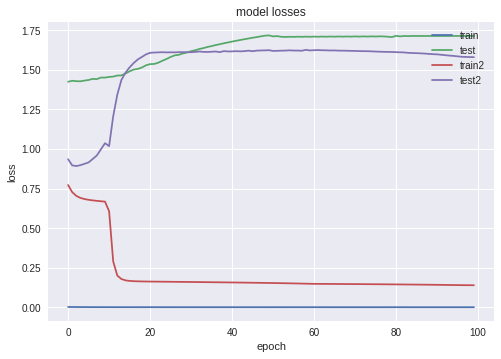

In [346]:
#@title Default title text
plt.plot(history['loss'][0:100])
plt.plot(history['val_loss'][0:100])
plt.plot(history2['loss'][0:100])
plt.plot(history2['val_loss'][0:100])
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test','train2', 'test2'], loc='upper right');



Here we usually see a large(separable) gap in model losses. When the random starting cisoid parameters are not ideal the training set can actually have a higer loss than the test set. This is something  that needs to be fixed. Of all the times I have ran the code though I have not seen an instance where the test accuracy is consistantly higher than the train accuracy. It may be higher on the first eopch. 

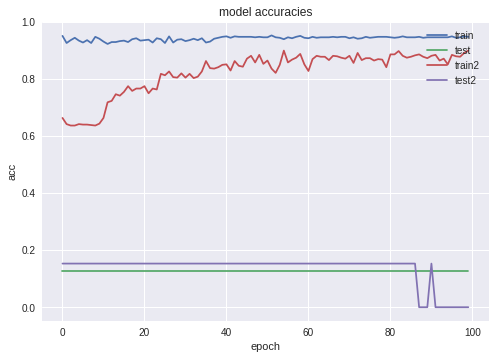

In [173]:
#@title Default title text
plt.plot(history['acc'][0:100])
plt.plot(history['val_acc'][0:100])
plt.plot(history2['acc'][0:100])
plt.plot(history2['val_acc'][0:100])
plt.title('model accuracies')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test','train2', 'test2'], loc='upper right');



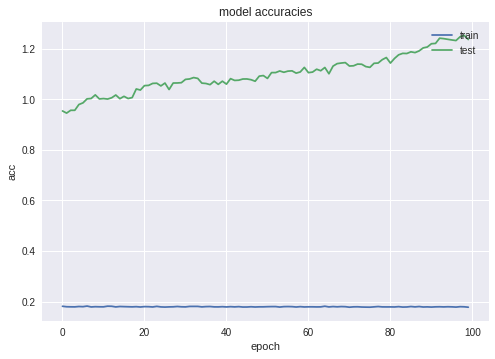

In [129]:
#@title Default title text
plt.plot(history['mean_absolute_error'][0:100])
plt.plot(history['val_mean_absolute_error'][0:100])
plt.title('model accuracies')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test','train2', 'test2'], loc='upper right');



Here we see the large(separable) gap in model losses. 

In [0]:
acc = keras.metrics.categorical_accuracy(x_test2,predictions)

import tensorflow as tf
from tensorflow.python.keras import backend as K
sess = K.get_session()
array = sess.run(acc)
#array = acc.eval(session=sess)


In [347]:
#@title Data Statistics

# Model 1 
predictions = autoencoder.predict(x_test2,batch_size=32)
mse = np.mean(np.power(x_test2 - predictions, 2), axis=1)
#acc = K.categorical_accuracy(x_test,predictions)
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': np.array(y_test)})

display(error_df.describe())

# # Model 2 

# predictions2 = autoencoder2.predict(x_test2,batch_size=32)
# mse2 = np.mean(np.power(x_test2 - predictions2, 2), axis=1)
# error_df2 = pd.DataFrame({'reconstruction_error': mse2,
#                          'true_class': np.array(y_test)})

# error_df2.describe()

,reconstruction_error,true_class
count,602.000000,602.000000
mean,0.836703,0.500000
std,0.056076,0.500416
min,0.780662,0.000000
25%,0.780674,0.000000
50%,0.836707,0.500000
75%,0.892733,1.000000
max,0.892742,1.000000


**Reconstruction error without Anomaly**

In [348]:
import tensorflow as tf
from tensorflow.python.keras import backend as K


acc = keras.metrics.categorical_accuracy(x_test2,predictions)
sess = K.get_session()
array = sess.run(acc)

test_accuracy = np.logical_xor(array,np.array(y_test))
np.sum(test_accuracy)



392

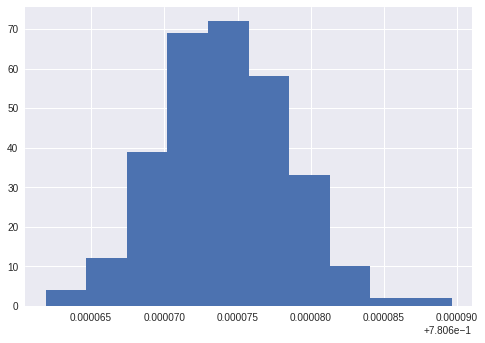

In [351]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 100000000000000000000000)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

**Reconstruction error with Anomaly**

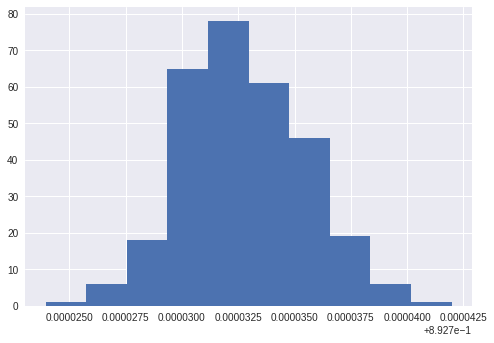

In [352]:
fig = plt.figure()
ax = fig.add_subplot(111)
anomaly_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(anomaly_error_df.reconstruction_error.values, bins=10)

In [0]:
threshold1 = (np.max(normal_error_df)['reconstruction_error'] + np.min(anomaly_error_df['reconstruction_error']))/2

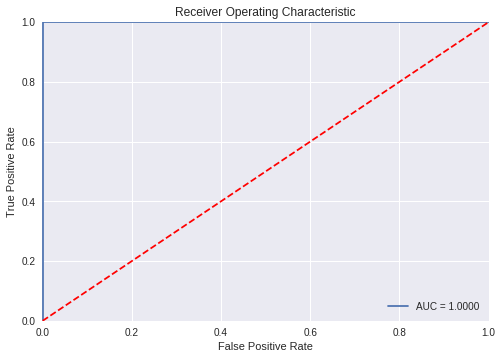

In [354]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

#fpr2, tpr2, thresholds2 = roc_curve(error_df2.true_class, error_df2.reconstruction_error)
#roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
#plt.plot(fpr2, tpr2, 'go',label='AUC 2 = %0.4f'% roc_auc2)

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();


# **Precision vs Recall**

Ideally one would have a system with both precision and recall equal to one. This would result in a unity plot. We want to maximize the area under the graph given that the range of values is 0 to 1. 

**Model 1**

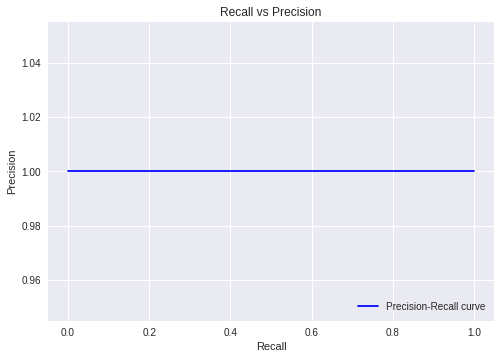

In [355]:
#@title Default title text
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
#precision2, recall2, th2 = precision_recall_curve(error_df2.true_class, error_df2.reconstruction_error)
#plt.plot(recall2, precision2, 'r--', label='Precision-Recall curve 2')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()

high precision ~ low false positives \\
high recall ~ low false negatives 

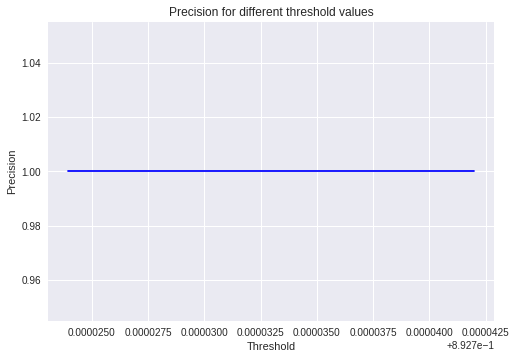

In [356]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

This run of the code shows near ideal retults. Here precision is not a function of reconstruction error.



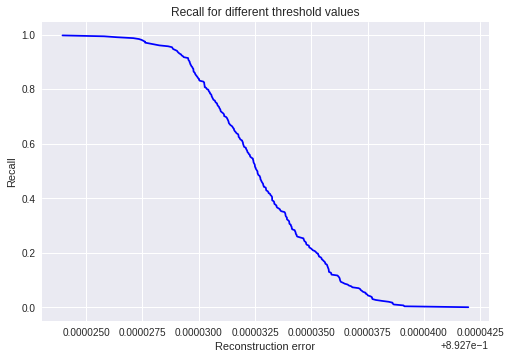

In [357]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here we see that as reconstruction error increases recall decreases. 





**Model 2**

In [358]:
predictions2 = autoencoder2.predict(x_test2,batch_size=32)
mse = np.mean(np.power(x_test2 - predictions2, 2), axis=1)
error_df2 = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': np.array(y_test)})

error_df2.describe()

,reconstruction_error,true_class
count,602.000000,602.000000
mean,1.575242,0.500000
std,1.438955,0.500416
min,0.137480,0.000000
25%,0.137482,0.000000
50%,1.575192,0.500000
75%,3.013003,1.000000
max,3.013102,1.000000


In [359]:
acc = keras.metrics.categorical_accuracy(x_test2,predictions2)
sess = K.get_session()
array = sess.run(acc)

test_accuracy = np.logical_xor(array,np.array(y_test))
np.sum(test_accuracy)

392

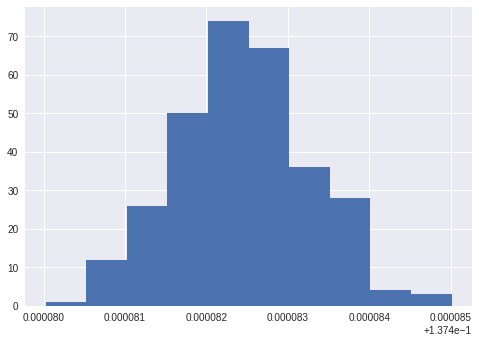

In [360]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df2 = error_df2[(error_df2['true_class']== 0) & (error_df2['reconstruction_error'] < 1000000000000)]
_ = ax.hist(normal_error_df2.reconstruction_error.values, bins=10)

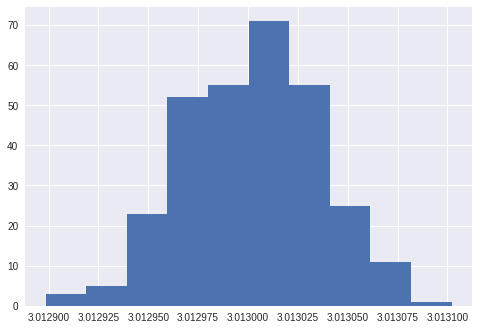

In [361]:
fig = plt.figure()
ax = fig.add_subplot(111)
anomaly_error_df2 = error_df2[error_df2['true_class'] == 1]
_ = ax.hist(anomaly_error_df2.reconstruction_error.values, bins=10)

In [0]:
threshold2 = (np.max(normal_error_df2)['reconstruction_error'] + np.min(anomaly_error_df2['reconstruction_error']))/2

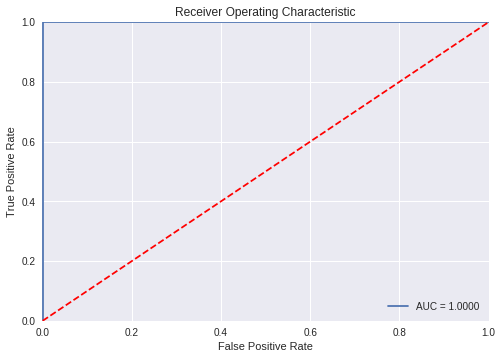

In [363]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr2, tpr2, thresholds = roc_curve(error_df2.true_class, error_df2.reconstruction_error)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr2, tpr2, label='AUC = %0.4f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

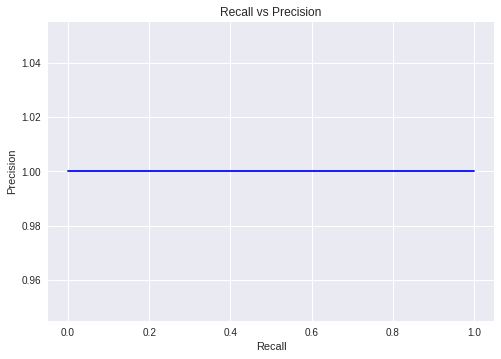

In [364]:
precision2, recall2, th2 = precision_recall_curve(error_df2.true_class, error_df2.reconstruction_error)
plt.plot(recall2, precision2, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()



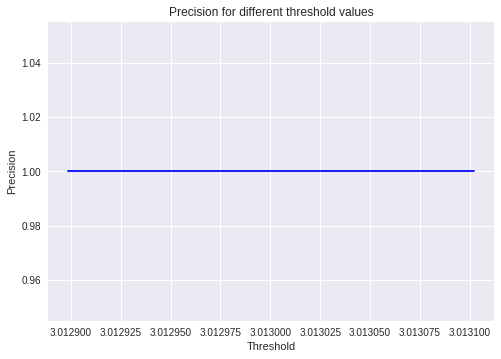

In [365]:
plt.plot(th2, precision2[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()



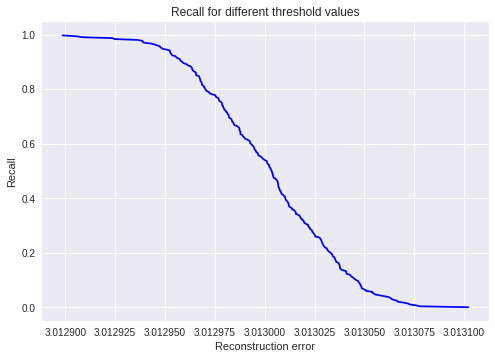

In [366]:
plt.plot(th2, recall2[1:], 'b', label='Threshold-Recall curve')
#plt.plot(th, recall[1:], 'r.', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

As in model 1 we see that as reconstruction error increases recall decreases. But it occurs at a much higher value here.

# **Prediction**

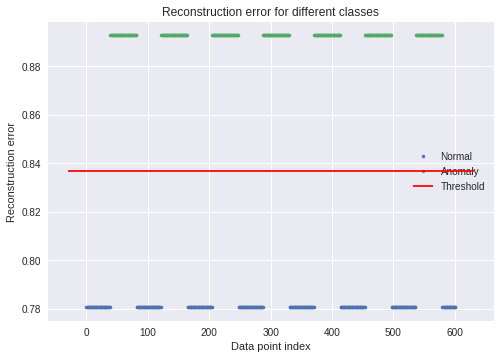

In [367]:
threshold = threshold1

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

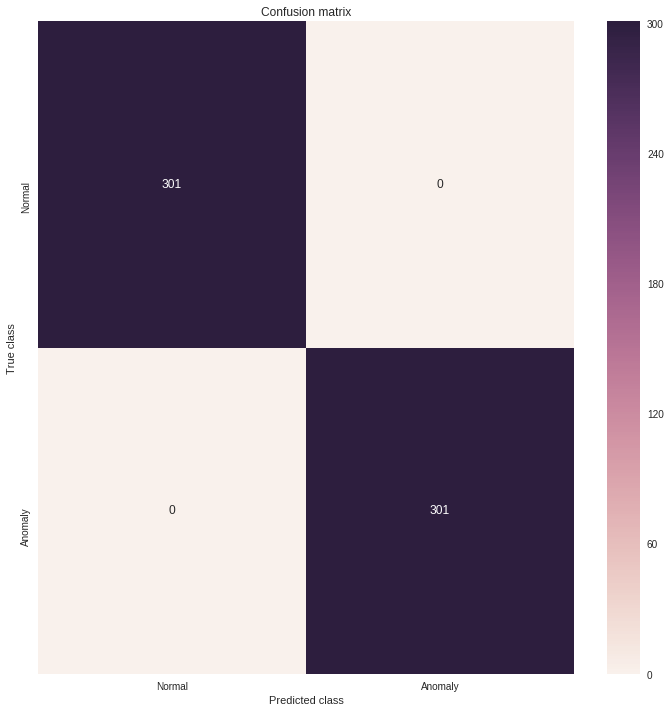

In [368]:
LABELS = ["Normal", "Anomaly"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



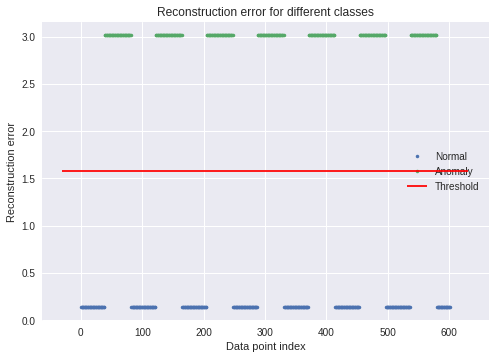

In [369]:
threshold = threshold2

groups = error_df2.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

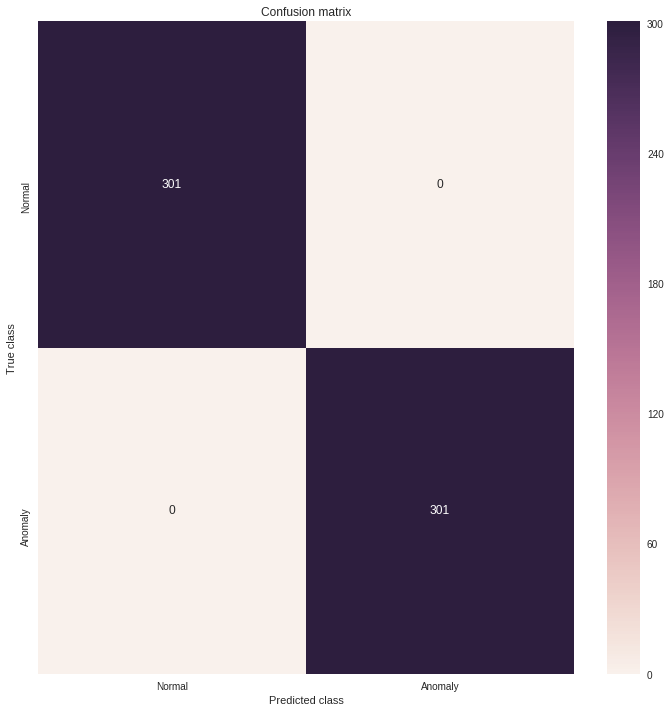

In [370]:
LABELS = ["Normal", "Anomaly"]
y_pred = [1 if e > threshold else 0 for e in error_df2.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

